#**EXPLAINING RECOMMENDER SYSTEM**

In the previous assignment our goal was to create a model for a recommender system concerning the Movielens Dataset, taking into account just the user_id and the item_id. Now, we have to embed the features regarding each user and each item. \\
To start, we took a look at the dataframe, in order to decide which features to keep and how to handle them. After the pre-processing stage we created the models and finally, to explain them, we used LIME, SHAP and the configure_interpretable_embedding_layer method. \\
Since we didn't want to find the best parameters for the models relying on just manual experimentations, we've also used the Optuna method to do it for us (however it gave bad results and we decided to do it manually). \\


##**SETTING ENVIRONMENT**

In [ ]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import torch.nn.init as init

In [ ]:
random.seed(17)
np.random.seed(17) # if I have poor performance, I can try to change the seed
torch.manual_seed(17)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_origin = {'100k': 'u.data'}

num_sample_data = '100k'
DATA_PATH = '/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.data'.format(dataset_origin[num_sample_data]) #change this with your directory
MODEL_PATH = '/content/drive/MyDrive/machine learning/ML and DL/ml-100k'.format(num_sample_data) #change this with your directory


##**CLEANING THE DATASET**

After adjusting the typos of the categorical values in the whole dataset, we removed 'IMDb_URL', 'release_date', 'video_release_date' and the 'title' features. In our opinion the Url and the title gave the same information of the item_id; the video release date contained NaN values only. For what concerns the release date, on 1682 films there were 240 release date different values only and neither NaN nor Null values. \\
In the dataframe, all the genres were hot-encoded (generating more then 40 different features). We decided to treat the genre as just 1 feature, each genre represented by an index. \\
For what concerns the occupations, we simply mapped the strings to indeces. \\
In the gender, we replaced 'M' as 1 and 'F' as 0. \\
The last important data manipulation was on the zip codes. We know that embedding layers require as num_embeddings argument the maximum possible value that can appear in that feature. The bigger this value, the more dimensions the embedding needs to work with. For this reason we decided to remap the zipcodes, in order to lighten the computations.

In [ ]:
# Read u.data
data_columns = ['user_id', 'item_id', 'rating', 'timestamp']
data_df = pd.read_csv('/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.data', sep="\t", names=data_columns)

# Read u.user
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
user_df = pd.read_csv('/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.user', sep='|', names=user_columns)

# Read u.item
item_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_df = pd.read_csv('/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.item', sep='|', names=item_columns, encoding='latin-1')

# DataFrame creation
ml_100k = data_df
ml_100k = pd.merge(ml_100k, user_df, on='user_id')
ml_100k = pd.merge(ml_100k, item_df, on='item_id')


In [ ]:
# Removing features
columns_to_remove = ['IMDb_URL','release_date','video_release_date','title']
ml_100k.drop(columns_to_remove, axis=1, inplace=True)
ml_100k.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,0,0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,0,0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,0,0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Genre manipulation
ml_100k_genre_df = ml_100k[['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
genre_new_df = pd.DataFrame()
genre_new_df['genre'] = ml_100k_genre_df.idxmax(axis=1)

# Mapping
mapping = {
    'unknown': 0,
    'Action': 1,
    'Adventure': 2,
    'Animation': 3,
    'Children': 4,
    'Comedy': 5,
    'Crime': 6,
    'Documentary': 7,
    'Drama': 8,
    'Fantasy': 9,
    'Film-Noir': 10,
    'Horror': 11,
    'Musical': 12,
    'Mystery': 13,
    'Romance': 14,
    'Sci-Fi': 15,
    'Thriller': 16,
    'War': 17,
    'Western': 18
}

genre_new_df['genre'] = genre_new_df['genre'].map(mapping)
colonne_to_remove = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ml_100k = ml_100k.drop(columns=colonne_to_remove)
ml_100k['genre'] = genre_new_df['genre']


In [ ]:
# Zip code cleaning
ml_100k = ml_100k[ml_100k['zip_code'].str.contains(r'^\d{5}$')]

# Index reset
ml_100k = ml_100k.reset_index(drop=True)

In [ ]:
# Gender mapping
ml_100k['gender'] = ml_100k['gender'].replace({'M': 1, 'F': 0})

In [ ]:
# Occupation mapping
mapping = {
    'writer': 0,
    'programmer': 1,
    'executive': 2,
    'retired': 3,
    'marketing': 4,
    'student': 5,
    'educator': 6,
    'engineer': 7,
    'other': 8,
    'technician': 9,
    'scientist': 10,
    'artist': 11,
    'administrator': 12,
    'lawyer': 13,
    'homemaker': 14,
    'librarian': 15,
    'entertainment': 16,
    'healthcare': 17,
    'none': 18,
    'salesman': 19,
    'doctor': 20
}
ml_100k['occupation'] = ml_100k['occupation'].map(mapping)

In [ ]:
# Zip code mapping
zip_code_rank = ml_100k['zip_code'].rank(method='dense').astype(int) - 1
zip_code_mapping = dict(zip(ml_100k['zip_code'].unique(), zip_code_rank.unique()))
ml_100k['zip_code'] = ml_100k['zip_code'].map(zip_code_mapping)

In [ ]:
# Final results
ml_100k.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,genre
0,196,242,3,881250949,49,1,0,415,5
1,305,242,5,886307828,23,1,1,690,5
2,6,242,4,883268170,42,1,2,758,5
3,234,242,4,891033261,60,1,3,707,5
4,63,242,3,875747190,31,1,4,542,5


##**DATA MANAGEMENT**

We edited the Rating_Datset and NCF_Data classes to work with the new features.

In [ ]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list, age_list, gender_list, occupation_list, zip_code_list, genre_list):
		super(Rating_Datset, self).__init__()

		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list
		self.age_list = age_list
		self.gender_list = gender_list
		self.occupation_list = occupation_list
		self.zip_code_list = zip_code_list
		self.genre_list = genre_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		age = self.age_list[idx]
		gender = self.gender_list[idx]
		occupation = self.occupation_list[idx]
		zip_code = self.zip_code_list[idx]
		genre = self.genre_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float),
	 		torch.tensor(age, dtype=torch.long),
			torch.tensor(gender, dtype=torch.long),
	 		torch.tensor(occupation, dtype=torch.long),
			torch.tensor(zip_code, dtype=torch.long),
	 		torch.tensor(genre, dtype=torch.long)
		)

In [ ]:
# Creating a genre list in which each genre has the same index of the item index in the dataframe (see below: _find_genre() function)

genre_vec = []
unique_items = ml_100k['item_id'].unique()

for i in unique_items:
    row = ml_100k.loc[ml_100k['item_id'] == i]

    if not row.empty:
        genre_vec.append(row['genre'].iloc[0])
    else:
        genre_vec.append(None)

In [ ]:
class NCF_Data(object):
    """
    Construct Dataset for NCF
    """
    def __init__(self, args, ratings):
        self.ratings = ratings
        self.num_ng = args.num_ng
        self.num_ng_test = args.num_ng_test
        self.batch_size = args.batch_size

        self.preprocess_ratings = self._reindex(self.ratings)

        self.user_pool = set(self.ratings['user_id'].unique())
        self.item_pool = set(self.ratings['item_id'].unique())

        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        self.negatives = self._negative_sampling(self.preprocess_ratings)

    def _find_genre(self, item):
        return int(genre_vec[item])

    def _reindex(self, ratings):
        """
        Process dataset to reindex userID and itemID, also set rating as binary feedback
        """
        user_list = list(ratings['user_id'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}

        item_list = list(ratings['item_id'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}

        ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
        ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
        ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))

        return ratings

    def _leave_one_out(self, ratings):
        """
        leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
        """
        ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)

        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]

        assert train['user_id'].nunique() == test['user_id'].nunique(), 'Not Match Train User with Test User'
        return train[['user_id', 'item_id', 'rating', 'age', 'gender', 'occupation', 'zip_code', 'genre']], test[['user_id', 'item_id', 'rating', 'age', 'gender', 'occupation', 'zip_code', 'genre']]

    def _negative_sampling(self, ratings):
        interact_status = (
            ratings.groupby('user_id')['item_id']
            .apply(set)
            .reset_index()
            .rename(columns={'item_id': 'interacted_items'}))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))

        return interact_status[['user_id', 'negative_items', 'negative_samples']]

    def get_train_instance(self):
        users, items, ratings, age, gender, occupation, zip_code, genre = [], [], [], [], [], [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))

        for row in tqdm(train_ratings.itertuples()):
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            age.append(int(row.age))
            gender.append(int(row.gender))
            occupation.append(int(row.occupation))
            zip_code.append(int(row.zip_code))
            genre.append(int(row.genre))

            for i in range(self.num_ng):
                users.append(int(row.user_id))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))
                age.append(int(row.age))
                gender.append(int(row.gender))
                occupation.append(int(row.occupation))
                zip_code.append(int(row.zip_code))
                genre.append(int(self._find_genre(int(row.negatives[i]))))

        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings,
            age_list=age,
            gender_list=gender,
            occupation_list=occupation,
            zip_code_list=zip_code,
            genre_list=genre
        )

        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def get_test_instance(self):
        users, items, ratings, age, gender, occupation, zip_code, genre = [], [], [], [], [], [], [], []
        test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')

        for row in test_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            age.append(int(row.age))
            gender.append(int(row.gender))
            occupation.append(int(row.occupation))
            zip_code.append(int(row.zip_code))
            genre.append(int(row.genre))

            for i in getattr(row, 'negative_samples'):
                users.append(int(row.user_id))
                items.append(int(i))
                ratings.append(float(0))
                age.append(int(row.age))
                gender.append(int(row.gender))
                occupation.append(int(row.occupation))
                zip_code.append(int(row.zip_code))
                genre.append(int(self._find_genre(i)))

        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings,
            age_list=age,
            gender_list=gender,
            occupation_list=occupation,
            zip_code_list=zip_code,
            genre_list=genre
        )

        return DataLoader(dataset, batch_size=self.num_ng_test + 1, shuffle=False, num_workers=2)

    def __str__(self):
        return f"NCF_Data: Train Ratings={len(self.train_ratings)}, Num Negative Samples={self.num_ng}, Num Negative Samples for Test={self.num_ng_test}, Batch Size={self.batch_size}"


In [ ]:
def hit(ng_item, pred_items):
    if ng_item in pred_items:
        return 1
    return 0

def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index+2))
    return 0

def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for user, item, label, age, gender, occupation, zip_code, genre in test_loader:
        user = user.to(device)
        item = item.to(device)
        age = age.to(device)
        gender = gender.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)

        predictions = model(user, item, age, gender, occupation, zip_code, genre)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        ng_item = item[0].item() # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)


In [ ]:
def plot_loss(hr, ndcg):
  plt.plot(range(len(hr)), hr, c='b', label='Hit Rate')
  plt.plot(range(len(ndcg)), ndcg, c='r', label='Normalized Discrete Cognitive Geometrical')
  plt.show()

##**PRE-TRAINING SINGLE MODELS**

Since the neural matrix factorization model consists of a combination of GMF and MLP, we decided to pre-train a GMF model and pre-train an MLP model, as we did in the first assignment.

In [ ]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed",
	type=int,
	default=42,
	help="Seed")
parser.add_argument("--lr",
	type=float,
	default=0.0005,
	help="learning rate")
parser.add_argument("--dropout",
	type=float,
	default=0.3,
	help="dropout rate")
parser.add_argument("--batch_size",
	type=int,
	default=1024,
	help="batch size for training")
parser.add_argument("--epochs",
	type=int,
	default=20,
	help="training epoches")
parser.add_argument("--top_k",
	type=int,
	default=10,
	help="compute metrics@top_k")
parser.add_argument("--factor_num",
	type=int,
	default=256,
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+',
    default=[256*7, 128, 1024, 64],
    help="MLP layers.")
parser.add_argument("--num_ng",
	type=int,
	default=4,
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test",
	type=int,
	default=100,
	help="Number of negative samples for test set")
parser.add_argument("--out",
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

In [ ]:
class GMF(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_age = num_age
        self.num_occupation = num_occupation
        self.num_zip_code = num_zip_code
        self.num_genre = num_genre
        self.num_gender = num_gender
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        self.embedding_age = nn.Embedding(num_embeddings=self.num_age, embedding_dim=self.factor_num)
        self.embedding_occupation = nn.Embedding(num_embeddings=self.num_occupation, embedding_dim=self.factor_num)
        self.embedding_zip_code = nn.Embedding(num_embeddings=self.num_zip_code, embedding_dim=self.factor_num)
        self.embedding_genre = nn.Embedding(num_embeddings=self.num_genre, embedding_dim=self.factor_num)
        self.embedding_gender = nn.Embedding(num_embeddings=self.num_gender, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)

        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        age_embedding = self.embedding_age(age_indices)
        occupation_embedding = self.embedding_occupation(occupation_indices)
        zip_code_embedding = self.embedding_zip_code(zip_code_indices)
        genre_embedding = self.embedding_genre(genre_indices)
        gender_embedding = self.embedding_gender(gender_indices)

        element_product = torch.mul(gender_embedding, age_embedding)
        element_product_1 = torch.mul(zip_code_embedding, occupation_embedding)
        element_product_2 = torch.mul(element_product, element_product_1)
        element_product_user = torch.mul(element_product_2, user_embedding)
        element_product_item = torch.mul(item_embedding, genre_embedding)
        element_product_tot = torch.mul(element_product_item, element_product_user)

        logits = self.affine_output(element_product_tot)
        rating = self.logistic(logits)
        return rating.squeeze()

In [ ]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_age = num_age
        self.num_gender = num_gender
        self.num_occupation = num_occupation
        self.num_zip_code = num_zip_code
        self.num_genre = num_genre
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        self.embedding_age = nn.Embedding(num_embeddings=self.num_age, embedding_dim=self.factor_num)
        self.embedding_occupation = nn.Embedding(num_embeddings=self.num_occupation, embedding_dim=self.factor_num)
        self.embedding_zip_code = nn.Embedding(num_embeddings=self.num_zip_code, embedding_dim=self.factor_num)
        self.embedding_genre = nn.Embedding(num_embeddings=self.num_genre, embedding_dim=self.factor_num)
        self.embedding_gender = nn.Embedding(num_embeddings=self.num_gender, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        age_embedding = self.embedding_age(age_indices)
        occupation_embedding = self.embedding_occupation(occupation_indices)
        zip_code_embedding = self.embedding_zip_code(zip_code_indices)
        genre_embedding = self.embedding_genre(genre_indices)
        gender_embedding = self.embedding_gender(gender_indices)

        vector = torch.cat([user_embedding, item_embedding, age_embedding, gender_embedding, occupation_embedding, zip_code_embedding, genre_embedding], dim=-1)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            vector = nn.Dropout(p=args.dropout)(vector)

        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()


In [ ]:
args = parser.parse_args("") # Viene parsato un set vuoto di argomenti utilizzando parser.parse_args(""). Questo istanzia un oggetto args contenente tutti gli argomenti necessari per l'addestramento del modello, i quali sono stati specificati precedentemente tramite un parser.

data = NCF_Data(args, ml_100k)
train = data.get_train_instance()
test = data.get_test_instance()

<ipython-input-227-ac1b59b9e1a6>:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-227-ac1b59b9e1a6>:64: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
96989it [00:00, 98966.70it/s] 
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

###**Train GMF**

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 001 time to train: 00: 01: 05
HR: 0.110	NDCG: 0.051
Epoch 002 time to train: 00: 01: 05
HR: 0.214	NDCG: 0.107
Epoch 003 time to train: 00: 01: 05
HR: 0.347	NDCG: 0.179
Epoch 004 time to train: 00: 01: 02
HR: 0.396	NDCG: 0.215
Epoch 005 time to train: 00: 01: 07
HR: 0.418	NDCG: 0.224
Epoch 006 time to train: 00: 01: 02
HR: 0.431	NDCG: 0.229
Epoch 007 time to train: 00: 01: 08
HR: 0.438	NDCG: 0.231
Epoch 008 time to train: 00: 01: 02
HR: 0.443	NDCG: 0.233
Epoch 009 time to train: 00: 01: 02
HR: 0.455	NDCG: 0.233
Epoch 010 time to train: 00: 01: 07
HR: 0.448	NDCG: 0.233
Epoch 011 time to train: 00: 01: 06
HR: 0.449	NDCG: 0.234
Epoch 012 time to train: 00: 01: 05
HR: 0.453	NDCG: 0.235
Epoch 013 time to train: 00: 01: 09
HR: 0.450	NDCG: 0.234
Epoch 014 time to train: 00: 01: 14
HR: 0.450	NDCG: 0.235
Epoch 015 time to train: 00: 01: 14
HR: 0.453	NDCG: 0.237
Epoch 016 time to train: 00: 01: 06
HR: 0.452	NDCG: 0.242
Epoch 017 time to train: 00: 01: 08
HR: 0.450	NDCG: 0.247
Epoch 018 time

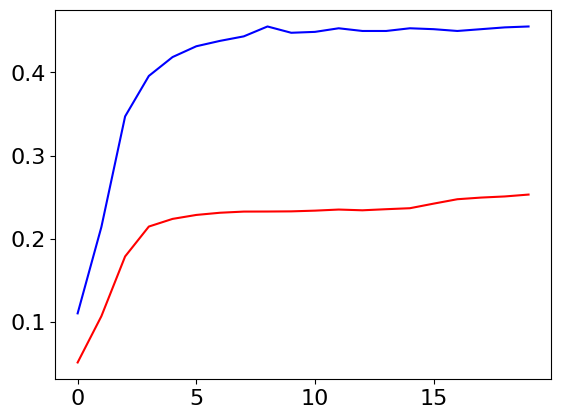

In [ ]:
num_users = ml_100k['user_id'].nunique() + 1
num_items = ml_100k['item_id'].nunique() + 1
num_age = int(ml_100k['age'].max()) + 1
num_occupation = int(ml_100k['occupation'].max()) + 1
num_zip_code = int(ml_100k['zip_code'].max()) + 1
num_genre = int(ml_100k['genre'].max()) + 1
num_gender = int(ml_100k['gender'].max()) + 1

# set model and loss, optimizer
model = GMF(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
hr_evolution = []
ndcg_evolution = []

for epoch in range(1, args.epochs+1):
    model.train()
    start_time = time.time()

    for user, item, label, age, gender, occupation, zip_code, genre in train:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        age = age.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)
        gender = gender.to(device)

        optimizer.zero_grad()
        prediction = model(user, item, age, gender, occupation, zip_code, genre)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test, args.top_k, device)

    elapsed_time = time.time() - start_time
    print("Epoch {:03d}".format(epoch) + " time to train: " +
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

    hr_evolution.append(HR)
    ndcg_evolution.append(NDCG)

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

plot_loss(hr_evolution, ndcg_evolution)


###**Train MLP**

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  5%|▌         | 1/20 [


 Epoch 001 time to train: 00: 01: 42
HR: 0.449	NDCG: 0.239 



 10%|█         | 2/20 [03:21<30:07, 100.42s/it]


 Epoch 002 time to train: 00: 01: 38
HR: 0.457	NDCG: 0.241 



 15%|█▌        | 3/20 [05:01<28:24, 100.25s/it]


 Epoch 003 time to train: 00: 01: 39
HR: 0.485	NDCG: 0.262 



 20%|██        | 4/20 [06:42<26:45, 100.36s/it]


 Epoch 004 time to train: 00: 01: 40
HR: 0.521	NDCG: 0.280 



 25%|██▌       | 5/20 [08:19<24:48, 99.23s/it] 


 Epoch 005 time to train: 00: 01: 37
HR: 0.555	NDCG: 0.311 



 30%|███       | 6/20 [10:01<23:22, 100.18s/it]


 Epoch 006 time to train: 00: 01: 41
HR: 0.598	NDCG: 0.336 



 35%|███▌      | 7/20 [11:38<21:30, 99.23s/it] 


 Epoch 007 time to train: 00: 01: 37
HR: 0.630	NDCG: 0.349 



 40%|████      | 8/20 [13:20<20:02, 100.20s/it]


 Epoch 008 time to train: 00: 01: 42
HR: 0.630	NDCG: 0.341 



 45%|████▌     | 9/20 [14:57<18:10, 99.09s/it] 


 Epoch 009 time to train: 00: 01: 36
HR: 0.643	NDCG: 0.358 



 50%|█████     | 10/20 [16:40<16:43, 100.31s/it]


 Epoch 010 time to train: 00: 01: 43
HR: 0.637	NDCG: 0.351 



 55%|█████▌    | 11/20 [18:16<14:51, 99.02s/it] 


 Epoch 011 time to train: 00: 01: 36
HR: 0.640	NDCG: 0.363 



 60%|██████    | 12/20 [19:51<13:00, 97.60s/it]


 Epoch 012 time to train: 00: 01: 34
HR: 0.643	NDCG: 0.355 



 65%|██████▌   | 13/20 [21:19<11:04, 94.95s/it]


 Epoch 013 time to train: 00: 01: 28
HR: 0.654	NDCG: 0.367 



 70%|███████   | 14/20 [22:46<09:14, 92.38s/it]


 Epoch 014 time to train: 00: 01: 26
HR: 0.627	NDCG: 0.353 



 75%|███████▌  | 15/20 [24:17<07:39, 91.98s/it]


 Epoch 015 time to train: 00: 01: 31
HR: 0.642	NDCG: 0.366 



 80%|████████  | 16/20 [25:47<06:05, 91.29s/it]


 Epoch 016 time to train: 00: 01: 29
HR: 0.638	NDCG: 0.356 



 85%|████████▌ | 17/20 [27:15<04:31, 90.57s/it]


 Epoch 017 time to train: 00: 01: 28
HR: 0.656	NDCG: 0.370 



 90%|█████████ | 18/20 [28:43<02:59, 89.70s/it]


 Epoch 018 time to train: 00: 01: 27
HR: 0.643	NDCG: 0.365 



 95%|█████████▌| 19/20 [30:12<01:29, 89.42s/it]


 Epoch 019 time to train: 00: 01: 28
HR: 0.634	NDCG: 0.369 



100%|██████████| 20/20 [31:38<00:00, 94.94s/it]


 Epoch 020 time to train: 00: 01: 26
HR: 0.641	NDCG: 0.360 



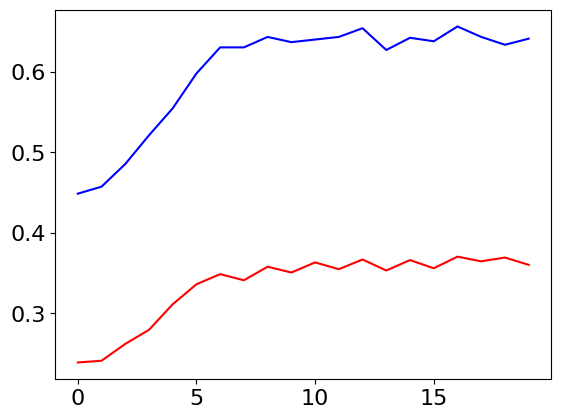

In [ ]:

# set the num_users, items
num_users = ml_100k['user_id'].nunique() + 1
num_items = ml_100k['item_id'].nunique() + 1
num_age = int(ml_100k['age'].max()) + 1
num_occupation = int(ml_100k['occupation'].max()) + 1
num_zip_code = int(ml_100k['zip_code'].max()) + 1
num_genre = int(ml_100k['genre'].max()) + 1
num_gender = int(ml_100k['gender'].max()) + 1

# set model and loss, optimizer
model = MLP(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
hr_evolution = []
ndcg_evolution = []

for epoch in tqdm(range(1, args.epochs + 1)):
    model.train()  # Enable dropout (if have).
    start_time = time.time()

    for user, item, label, age, gender, occupation, zip_code, genre in train:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        age = age.to(device)
        gender = gender.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)

        optimizer.zero_grad()
        prediction = model(user, item, age, gender, occupation, zip_code, genre)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        # writer.add_scalar('loss/Train_loss', loss.item(), epoch)

    scheduler.step()
    model.eval()
    HR, NDCG = metrics(model, test, args.top_k, device)
    # writer.add_scalar('Perfomance/HR@10', HR, epoch)
    # writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

    elapsed_time = time.time() - start_time
    print("\n Epoch {:03d}".format(epoch) + " time to train: " +
          time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)),"\n")

    hr_evolution.append(HR)
    ndcg_evolution.append(NDCG)

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

plot_loss(hr_evolution, ndcg_evolution)

##**NMF**

In [ ]:
class GMF_NMF(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(GMF_NMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_age = num_age
        self.num_occupation = num_occupation
        self.num_zip_code = num_zip_code
        self.num_genre = num_genre
        self.num_gender = num_gender
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        self.embedding_age = nn.Embedding(num_embeddings=self.num_age, embedding_dim=self.factor_num)
        self.embedding_occupation = nn.Embedding(num_embeddings=self.num_occupation, embedding_dim=self.factor_num)
        self.embedding_zip_code = nn.Embedding(num_embeddings=self.num_zip_code, embedding_dim=self.factor_num)
        self.embedding_genre = nn.Embedding(num_embeddings=self.num_genre, embedding_dim=self.factor_num)
        self.embedding_gender = nn.Embedding(num_embeddings=self.num_gender, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        age_embedding = self.embedding_age(age_indices)
        occupation_embedding = self.embedding_occupation(occupation_indices)
        zip_code_embedding = self.embedding_zip_code(zip_code_indices)
        genre_embedding = self.embedding_genre(genre_indices)
        gender_embedding = self.embedding_gender(gender_indices)

        element_product = torch.mul(gender_embedding, age_embedding)
        element_product_1 = torch.mul(zip_code_embedding, occupation_embedding)
        element_product_2 = torch.mul(element_product, element_product_1)
        element_product_user = torch.mul(element_product_2, user_embedding)
        element_product_item = torch.mul(item_embedding, genre_embedding)
        element_product_tot = torch.mul(element_product_item, element_product_user)

        return element_product_tot

class MLP_NMF(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(MLP_NMF, self).__init__()
        self.num_users = num_users # Salva il numero totale di utenti come attributo dell'istanza MLP.
        self.num_items = num_items # Salva il numero totale di elementi come attributo dell'istanza MLP.
        self.num_age = num_age
        self.num_gender = num_gender
        self.num_occupation = num_occupation
        self.num_zip_code = num_zip_code
        self.num_genre = num_genre
        self.factor_num = args.factor_num #  Salva il numero di fattori (dimensione dell'embedding) da usare come attributo dell'istanza MLP, preso dagli argomenti args.
        self.layers = args.layers # Salva la configurazione dei layer fully connected come attributo dell'istanza MLP, anch'esso preso dagli argomenti args.

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num, ) # Questa riga definisce un layer di embedding per gli utenti. num_embeddings è impostato sul numero totale di utenti, e embedding_dim è impostato sulla dimensione del fattore.
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num) # Questa riga definisce un layer di embedding per gli elementi con gli stessi parametri di embedding degli utenti.
        self.embedding_age = nn.Embedding(num_embeddings=self.num_age, embedding_dim=self.factor_num)
        self.embedding_occupation = nn.Embedding(num_embeddings=self.num_occupation, embedding_dim=self.factor_num)
        self.embedding_zip_code = nn.Embedding(num_embeddings=self.num_zip_code, embedding_dim=self.factor_num)
        self.embedding_genre = nn.Embedding(num_embeddings=self.num_genre, embedding_dim=self.factor_num)
        self.embedding_gender = nn.Embedding(num_embeddings=self.num_gender, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList() # Questa riga crea un oggetto ModuleList, che è una lista di moduli, per contenere i layer fully connected.
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])): #  Questa riga itera attraverso le coppie di dimensioni di input e output per i layer fully connected. enumerate restituisce sia l'indice (idx) che l'elemento ((in_size, out_size)) per ogni elemento della lista.
            self.fc_layers.append(nn.Linear(in_size, out_size)) # Per ogni coppia di dimensioni, viene creato un nuovo layer fully connected con dimensioni di input e output corrispondenti e aggiunto alla lista fc_layers.

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices): # Questa riga definisce il metodo forward della classe MLP, che specifica il flusso dei dati attraverso il modello.
        user_embedding = self.embedding_user(user_indices) # Calcola l'embedding per gli utenti corrispondenti agli indici dati.
        item_embedding = self.embedding_item(item_indices) # Calcola l'embedding per gli elementi corrispondenti agli indici dati.
        age_embedding = self.embedding_age(age_indices) # Calcola l'embedding per gli elementi corrispondenti agli indici dati.
        occupation_embedding = self.embedding_occupation(occupation_indices) # Calcola l'embedding per gli elementi corrispondenti agli indici dati.
        zip_code_embedding = self.embedding_zip_code(zip_code_indices) # Calcola l'embedding per gli elementi corrispondenti agli indici dati.
        genre_embedding = self.embedding_genre(genre_indices) # Calcola l'embedding per gli elementi corrispondenti agli indici dati.
        gender_embedding = self.embedding_gender(gender_indices) # Calcola l'embedding per gli elementi corrispondenti agli indici dati.

        vector = torch.cat([user_embedding, item_embedding, age_embedding, gender_embedding, occupation_embedding, zip_code_embedding, genre_embedding], dim=-1)

        for idx, _ in enumerate(range(len(self.fc_layers))): # Itera attraverso i layer fully connected.
            vector = self.fc_layers[idx](vector) # Applica il layer fully connected corrente al vettore di input.
            vector = nn.ReLU()(vector) # Applica la funzione di attivazione ReLU al vettore di output del layer fully connected.
            # vector = nn.BatchNorm1d()(vector)
            vector = nn.Dropout(p=args.dropout)(vector)

        return vector # Restituisce il rating previsto dopo aver rimosso eventuali dimensioni superflue.


In [ ]:
class NeuMF_Completed(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(NeuMF_Completed, self).__init__()

        self.GMFModel = GMF_NMF(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)
        self.MLPModel = MLP_NMF(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)

        self.GMFModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kGMF.pt", map_location=torch.device('cpu')))
        self.MLPModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kMLP.pt", map_location=torch.device('cpu')))

        self.affine_output = nn.Linear(in_features=args.factor_num + args.layers[-1], out_features=1) #last mlp layer + fac number
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices):

        # MLP PART

        MLP_res = self.MLPModel(user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices)

        # MF PART

        GMF_res = self.GMFModel(user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices)

        # FINAL RESULT

        result = torch.cat([MLP_res, GMF_res], dim=-1)
        result = self.affine_output(result)

        result = self.logistic(result)

        return result.squeeze()


**NMF Training**

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  5%|▌         | 1/20 [01:30<28:32, 90.12s/it]


 Epoch 001 time to train: 00: 01: 30
HR: 0.644	NDCG: 0.368 



 10%|█         | 2/20 [03:02<27:29, 91.64s/it]


 Epoch 002 time to train: 00: 01: 32
HR: 0.626	NDCG: 0.357 



 15%|█▌        | 3/20 [04:31<25:33, 90.19s/it]


 Epoch 003 time to train: 00: 01: 28
HR: 0.611	NDCG: 0.351 



 20%|██        | 4/20 [06:03<24:15, 90.98s/it]


 Epoch 004 time to train: 00: 01: 32
HR: 0.615	NDCG: 0.352 



 25%|██▌       | 5/20 [07:33<22:41, 90.80s/it]


 Epoch 005 time to train: 00: 01: 30
HR: 0.619	NDCG: 0.352 



 30%|███       | 6/20 [09:03<21:06, 90.47s/it]


 Epoch 006 time to train: 00: 01: 29
HR: 0.621	NDCG: 0.353 



 35%|███▌      | 7/20 [10:39<20:00, 92.33s/it]


 Epoch 007 time to train: 00: 01: 36
HR: 0.616	NDCG: 0.349 



 40%|████      | 8/20 [12:09<18:18, 91.54s/it]


 Epoch 008 time to train: 00: 01: 29
HR: 0.625	NDCG: 0.355 



 45%|████▌     | 9/20 [13:47<17:06, 93.36s/it]


 Epoch 009 time to train: 00: 01: 37
HR: 0.599	NDCG: 0.345 



 50%|█████     | 10/20 [15:17<15:24, 92.44s/it]


 Epoch 010 time to train: 00: 01: 30
HR: 0.596	NDCG: 0.340 



 55%|█████▌    | 11/20 [16:52<13:59, 93.30s/it]


 Epoch 011 time to train: 00: 01: 35
HR: 0.602	NDCG: 0.345 



 60%|██████    | 12/20 [18:23<12:20, 92.56s/it]


 Epoch 012 time to train: 00: 01: 30
HR: 0.606	NDCG: 0.351 



 65%|██████▌   | 13/20 [20:00<10:58, 94.00s/it]


 Epoch 013 time to train: 00: 01: 37
HR: 0.613	NDCG: 0.354 



 70%|███████   | 14/20 [21:32<09:19, 93.33s/it]


 Epoch 014 time to train: 00: 01: 31
HR: 0.608	NDCG: 0.350 



 75%|███████▌  | 15/20 [23:06<07:47, 93.53s/it]


 Epoch 015 time to train: 00: 01: 33
HR: 0.599	NDCG: 0.347 



 80%|████████  | 16/20 [24:40<06:14, 93.58s/it]


 Epoch 016 time to train: 00: 01: 33
HR: 0.612	NDCG: 0.352 



 85%|████████▌ | 17/20 [26:12<04:39, 93.10s/it]


 Epoch 017 time to train: 00: 01: 31
HR: 0.609	NDCG: 0.347 



 90%|█████████ | 18/20 [27:51<03:09, 94.76s/it]


 Epoch 018 time to train: 00: 01: 38
HR: 0.609	NDCG: 0.353 



 95%|█████████▌| 19/20 [29:24<01:34, 94.32s/it]


 Epoch 019 time to train: 00: 01: 33
HR: 0.603	NDCG: 0.349 



100%|██████████| 20/20 [31:01<00:00, 93.06s/it]


 Epoch 020 time to train: 00: 01: 36
HR: 0.599	NDCG: 0.352 



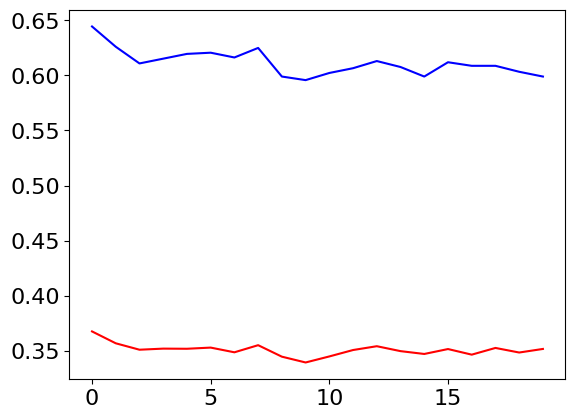

In [ ]:
num_users = ml_100k['user_id'].nunique() + 1
num_items = ml_100k['item_id'].nunique() + 1
num_age = int(ml_100k['age'].max()) + 1
num_occupation = int(ml_100k['occupation'].max()) + 1
num_zip_code = int(ml_100k['zip_code'].max()) + 1
num_genre = int(ml_100k['genre'].max()) + 1
num_gender = int(ml_100k['gender'].max()) + 1

# set model and loss, optimizer
model = NeuMF_Completed(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
hr_evolution = []
ndcg_evolution = []

best_hr = 0
for epoch in tqdm(range(1, args.epochs+1)):
    model.train()
    start_time = time.time()

    for user, item, label, age, gender, occupation, zip_code, genre in train:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        age = age.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)
        gender = gender.to(device)

        optimizer.zero_grad()
        prediction = model(user, item, age, gender, occupation, zip_code, genre)

        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test, args.top_k, device)

    elapsed_time = time.time() - start_time
    print("\n Epoch {:03d}".format(epoch) + " time to train: " +
          time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)), "\n")

    hr_evolution.append(HR)
    ndcg_evolution.append(NDCG)

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

plot_loss(hr_evolution, ndcg_evolution)


As we can clearly see, the composed model does not improve with time, and the MLP model by itself it's even better. This suggests that the MLP architecture is better to deal with multiple features instead of using a model containing a GMF, which has lower results then the MLP one (if we check the single model performances). We could have also given more space for improvement to the NeuMF model by means of using a lower learning rate or a higher dropout rate. \\

Finally, our new models have not better performances then the ones we built for the first assignment. This could be due by the choice of feature selection and embedding into the model: we could have done an hot-encoding of the features instead of embedding, for e.g., all the genres and occupations within a 'genre' and 'occupation' feature, giving then the models more dimensions to explore.

#**LIME (for NeuMF)**

We apply LIME for NeuMF model interpretation

In [ ]:
!pip install captum
import seaborn as sns
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import DeepLift, KernelShap, DeepLiftShap, ShapleyValueSampling

from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function

In [ ]:
num_users = ml_100k['user_id'].nunique() + 1
num_items = ml_100k['item_id'].nunique() + 1
num_age = int(ml_100k['age'].max()) + 1
num_occupation = int(ml_100k['occupation'].max()) + 1
num_zip_code = int(ml_100k['zip_code'].max()) + 1
num_genre = int(ml_100k['genre'].max()) + 1
num_gender = int(ml_100k['gender'].max()) + 1

model = NeuMF_Completed(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)

In [ ]:
# Creating the training dataset for LIME

X_train = data.train_ratings
y_train = X_train['rating'] # labels
X_train = X_train.drop(columns = ['rating'], axis=1) # features

X = X_train.values
y = y_train.values

X_tensor = torch.tensor(X).type(torch.IntTensor)
y_tensor = torch.tensor(y).type(torch.IntTensor)

In [ ]:
#let's define the similarity kernel
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

#let's instatiate the LIME algorithm
lr_lime = Lime(
    model,
    interpretable_model=SkLearnLinearRegression(),  # built-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance,
)

# Selecting the subject and its features
idx = 30
user_In = X_tensor[idx,0].view(1, -1)
item_In = X_tensor[idx,1].view(1, -1)
age_In = X_tensor[idx,2].view(1, -1)
gender_In = X_tensor[idx,3].view(1, -1)
occupation_In = X_tensor[idx,4].view(1, -1)
zip_code_In = X_tensor[idx,5].view(1, -1)
genre_In = X_tensor[idx,6].view(1, -1)

label = y_tensor[idx].item()

# We pass a tuple of tensors in the forward of the model
input_tuple = (user_In, item_In, age_In, gender_In, occupation_In, zip_code_In, genre_In)

# Compute attributions for each feature
attr = lr_lime.attribute(inputs=input_tuple, target=None, n_samples=1000) # in Captum documentation: if the label is an integer value, select 'None' for 'target'


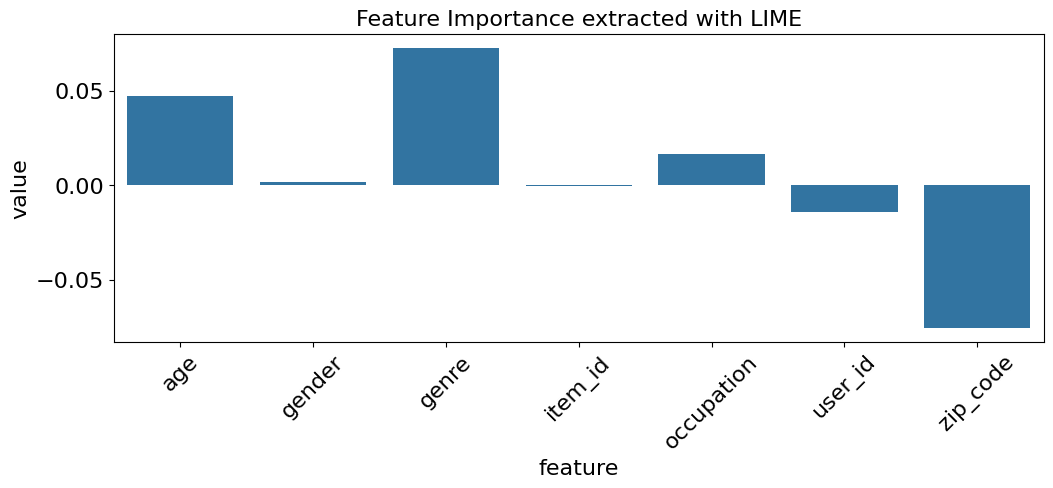

In [ ]:
# Let's plot!
dat = []

for idx, tensor in enumerate(attr):
    value = tensor.item()
    feature_name = data.train_ratings.drop(['rating'], axis=1).columns[idx]
    dat.append([value, feature_name])

# Creating a dataframe for attributions
attr_df = pd.DataFrame(dat, columns=['value', 'feature'])

# Let's convert the feature columns to 'category' type
attr_df['feature'] = attr_df['feature'].astype('category')

# Plot
plt.figure(figsize=(12, 4))
ax = sns.barplot(x='feature', y='value', data=attr_df)
ax.set(title='Feature Importance extracted with LIME')
plt.xticks(rotation=45)
plt.show()


Here we can see how the genre of the films and the age of each user is important for the final result, while for what concerns the zip_code it was a bad helper for the optimality.

#**SHAP (FOR NeuMF)**

We apply SHAP for NeuMF model interpretation

In [ ]:
model = NeuMF_Completed(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)

In [ ]:
# Creating the dataset for SHAP
X_test = data.test_ratings
y_test = X_test['rating']
X_test = X_test.drop(columns = ['rating'], axis=1)

X = X_test.values
y = y_test.values

X_tensor = torch.tensor(X).type(torch.IntTensor)
y_tensor = torch.tensor(y).type(torch.IntTensor)

# Exctracting the subject and its features
idx = 30
user_In = X_tensor[idx,0].view(1, -1)
item_In = X_tensor[idx,1].view(1, -1)
age_In = X_tensor[idx,2].view(1, -1)
gender_In = X_tensor[idx,3].view(1, -1)
occupation_In = X_tensor[idx,4].view(1, -1)
zip_code_In = X_tensor[idx,5].view(1, -1)
genre_In = X_tensor[idx,6].view(1, -1)

label = y_tensor[idx].item()

# As before, we pass a tuple of tensors in the forward of the model
input_tuple = (user_In, item_In, age_In, gender_In, occupation_In, zip_code_In, genre_In)

In [ ]:
# Attribute methods
svs = ShapleyValueSampling(model)
ks = KernelShap(model)

svs_attr_test = svs.attribute(input_tuple, target=None)
ks_attr_test = ks.attribute(input_tuple, target=None)

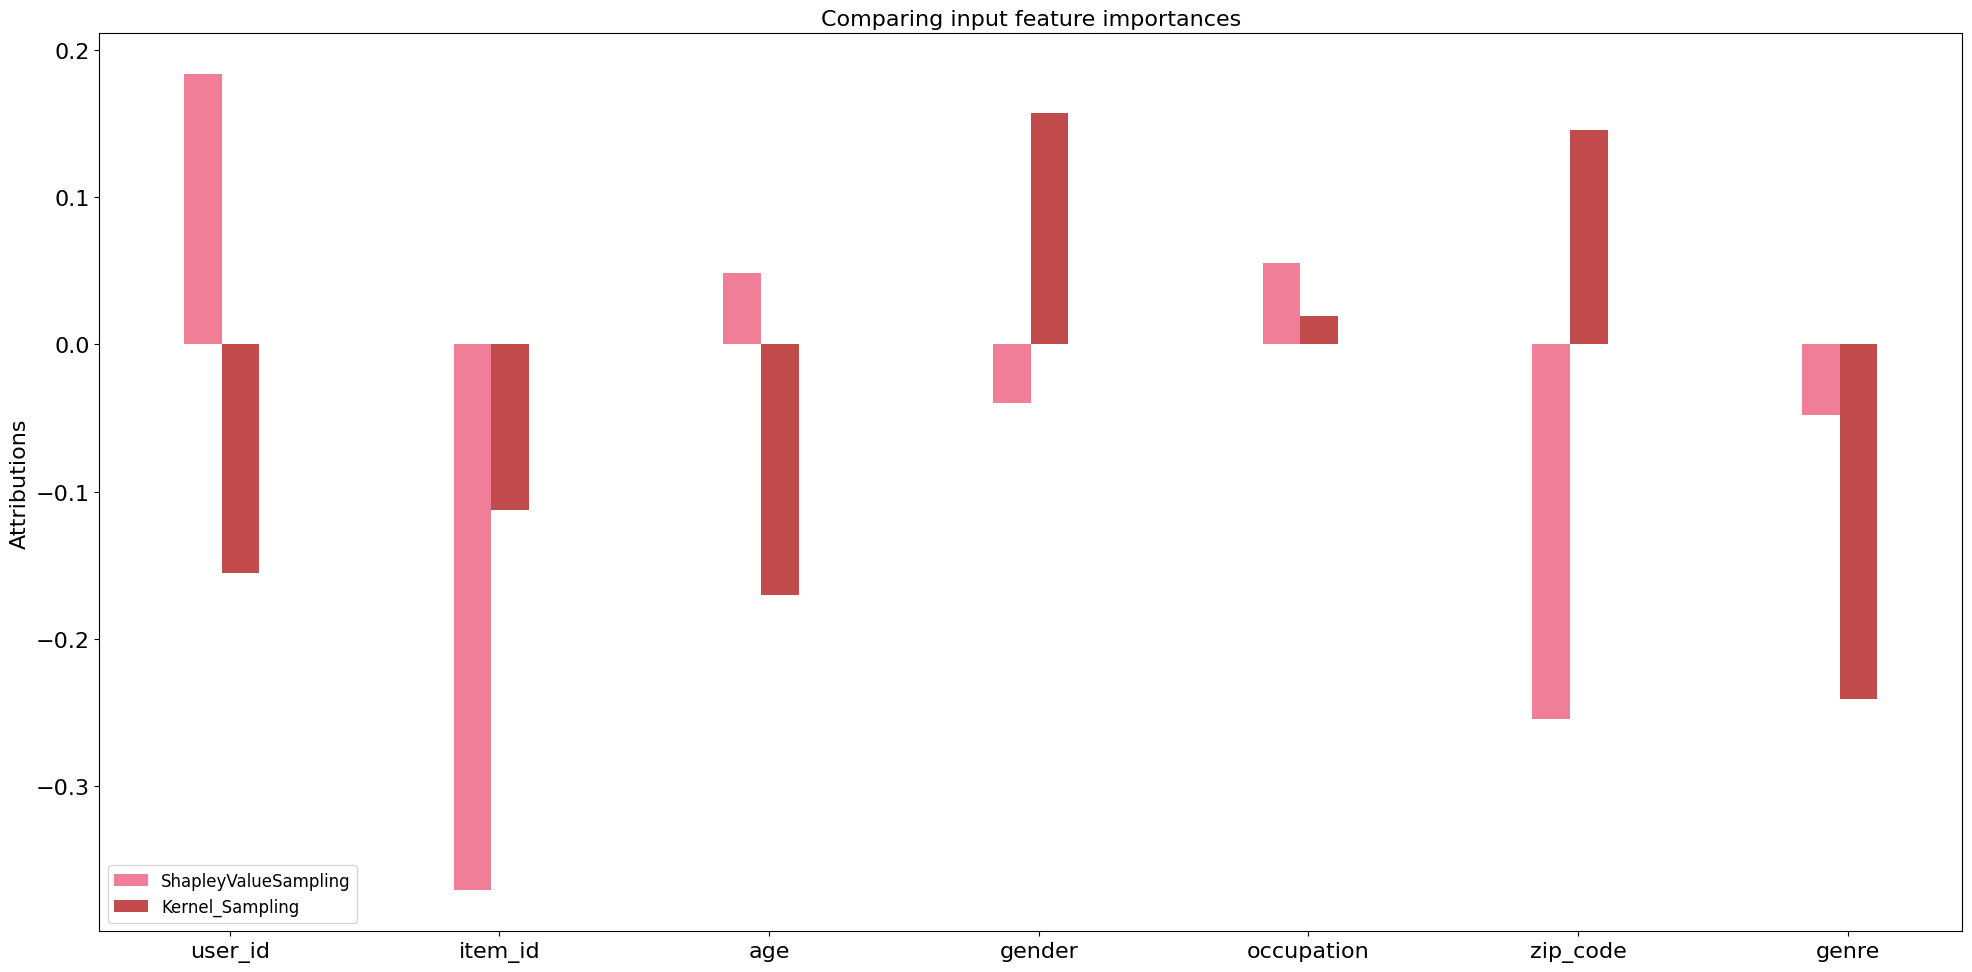

In [ ]:
# prepare attributions for visualization

feature_names = X_test.columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

svs_attr_test = torch.cat(svs_attr_test)
svs_attr_test_sum = svs_attr_test.detach().numpy().sum(1)
svs_attr_test_norm_sum = svs_attr_test_sum / np.linalg.norm(svs_attr_test_sum, ord=1)

ks_attr_test = torch.cat(ks_attr_test)
ks_attr_test_sum = ks_attr_test.detach().numpy().sum(1)
ks_attr_test_norm_sum = ks_attr_test_sum / np.linalg.norm(ks_attr_test_sum, ord=1)

width = 0.14
legends = ['ShapleyValueSampling', 'Kernel_Sampling']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, svs_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ks_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.1)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

Important to notice how much different the results are, depending on the algorithm used. Occupation is the only feature with similar results.

#**EXPLAINABLE EMBEDDINGS**

##**MLP**

We use configure_interpretable_embedding_layer in order to interpret the importance of each embedding for the output prediction regarding the single MLP model.




In [ ]:
model = MLP(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)

In [ ]:
# INTERPRETABLE EMBEDDINGS FOR MLP

from captum.attr import configure_interpretable_embedding_layer
from captum.attr import remove_interpretable_embedding_layer
from captum.attr import IntegratedGradients

# Configuration and setting of the interpretable embeddings
config_user = configure_interpretable_embedding_layer(model, 'embedding_user')
config_item = configure_interpretable_embedding_layer(model, 'embedding_item')
config_age = configure_interpretable_embedding_layer(model, 'embedding_age')
config_gender = configure_interpretable_embedding_layer(model, 'embedding_gender')
config_occupation = configure_interpretable_embedding_layer(model, 'embedding_occupation')
config_zip_code = configure_interpretable_embedding_layer(model, 'embedding_zip_code')
config_genre = configure_interpretable_embedding_layer(model, 'embedding_genre')

input_emb_user = config_user.indices_to_embeddings(user_In)
input_emb_item = config_item.indices_to_embeddings(item_In)
input_emb_age = config_age.indices_to_embeddings(age_In)
input_emb_gender = config_gender.indices_to_embeddings(gender_In)
input_emb_occupation = config_occupation.indices_to_embeddings(occupation_In)
input_emb_zip_code = config_zip_code.indices_to_embeddings(zip_code_In)
input_emb_genre = config_genre.indices_to_embeddings(genre_In)

# We use IntegratedGradients to compute the attributions of each embedding in the model.
# These attributions show how much each embedding contributes to the output prediction, telling us which features are more relevant

ig = IntegratedGradients(model)

new_input_tuple = (input_emb_user, input_emb_item, input_emb_age, input_emb_gender, input_emb_occupation, input_emb_zip_code, input_emb_genre)
attributions = ig.attribute(inputs=(new_input_tuple),
                            baselines=(user_In, item_In, age_In, gender_In, occupation_In, zip_code_In, genre_In)
                            )

# Removing the interpretable embeddings
remove_interpretable_embedding_layer(model, config_user)
remove_interpretable_embedding_layer(model, config_item)
remove_interpretable_embedding_layer(model, config_age)
remove_interpretable_embedding_layer(model, config_occupation)
remove_interpretable_embedding_layer(model, config_zip_code)
remove_interpretable_embedding_layer(model, config_genre)
remove_interpretable_embedding_layer(model, config_gender)

/usr/local/lib/python3.10/dist-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


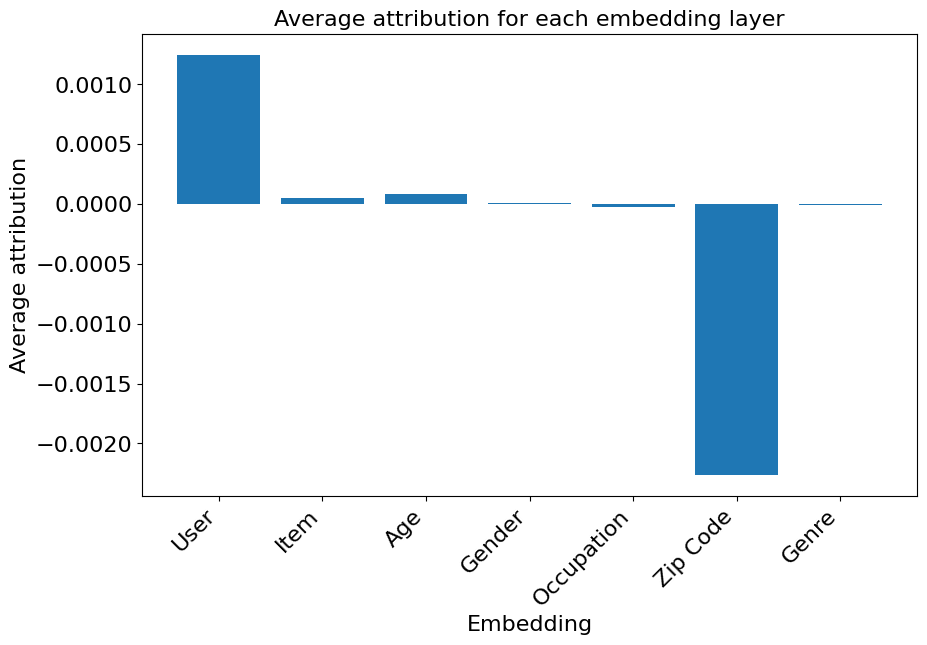

In [ ]:
# Let's plot!

mean_attributions_list_MLP = []
attributions_new = (attributions[0], attributions[1])

for attribution_tensor in attributions:
    attributions_array = attribution_tensor.squeeze().detach().numpy()
    mean_attributions = np.mean(attributions_array)

    mean_attributions_list_MLP.append(mean_attributions)

embedding_labels = ['User', 'Item', 'Age', 'Gender', 'Occupation', 'Zip Code', 'Genre']

plt.figure(figsize=(10, 6))
plt.bar(embedding_labels, mean_attributions_list_MLP)
plt.xlabel('Embedding')
plt.ylabel('Average attribution')
plt.title('Average attribution for each embedding layer')
plt.xticks(rotation=45, ha='right')
plt.show()

## **GMF**

We use configure_interpretable_embedding_layer in order to interpret the importance of each embedding for the output predictionin the case of the GMF model.


In [ ]:
model = GMF(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)

In [ ]:
from captum.attr import configure_interpretable_embedding_layer
from captum.attr import remove_interpretable_embedding_layer
from captum.attr import IntegratedGradients

# Configuration and setting of the interpretable embeddings
config_user = configure_interpretable_embedding_layer(model, 'embedding_user')
config_item = configure_interpretable_embedding_layer(model, 'embedding_item')
config_age = configure_interpretable_embedding_layer(model, 'embedding_age')
config_occupation = configure_interpretable_embedding_layer(model, 'embedding_occupation')
config_zip_code = configure_interpretable_embedding_layer(model, 'embedding_zip_code')
config_genre = configure_interpretable_embedding_layer(model, 'embedding_genre')
config_gender = configure_interpretable_embedding_layer(model, 'embedding_gender')

input_emb_user = config_user.indices_to_embeddings(user_In)
input_emb_item = config_item.indices_to_embeddings(item_In)
input_emb_age = config_age.indices_to_embeddings(age_In)
input_emb_occupation = config_occupation.indices_to_embeddings(occupation_In)
input_emb_zip_code = config_zip_code.indices_to_embeddings(zip_code_In)
input_emb_genre = config_genre.indices_to_embeddings(genre_In)
input_emb_gender = config_gender.indices_to_embeddings(gender_In)

# We use IntegratedGradients to compute the attributions of each embedding in the model.
# These attributions show how much each embedding contributes to the output prediction, telling us which features are more relevant

ig = IntegratedGradients(model)

new_input_tuple = (input_emb_user, input_emb_item, input_emb_age, input_emb_gender, input_emb_occupation, input_emb_zip_code, input_emb_genre)
attributions = ig.attribute(inputs=(new_input_tuple),
                            baselines=(user_In, item_In, age_In, gender_In, occupation_In, zip_code_In, genre_In)
                            )

remove_interpretable_embedding_layer(model, config_user)
remove_interpretable_embedding_layer(model, config_item)
remove_interpretable_embedding_layer(model, config_age)
remove_interpretable_embedding_layer(model, config_occupation)
remove_interpretable_embedding_layer(model, config_zip_code)
remove_interpretable_embedding_layer(model, config_genre)
remove_interpretable_embedding_layer(model, config_gender)

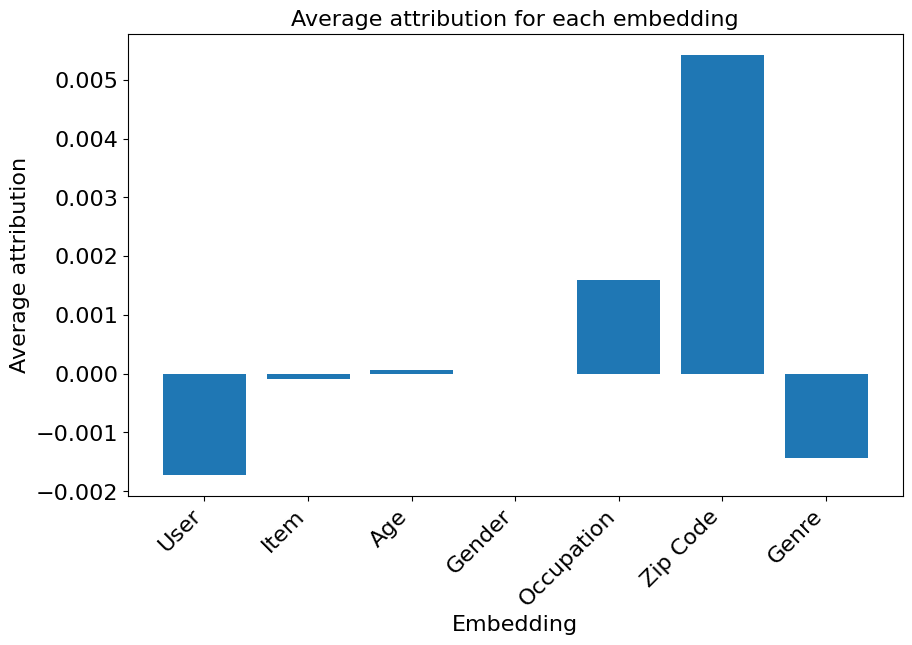

In [ ]:
# Let's plot!
mean_attributions_list = []

for attribution_tensor in attributions:
    attributions_array = attribution_tensor.squeeze().detach().numpy()
    mean_attributions = np.mean(attributions_array)

    mean_attributions_list.append(mean_attributions)

mean_attributions_list

embedding_labels = ['User', 'Item', 'Age', 'Gender', 'Occupation', 'Zip Code', 'Genre']

plt.figure(figsize=(10, 6))
plt.bar(embedding_labels, mean_attributions_list)
plt.xlabel('Embedding')
plt.ylabel('Average attribution')
plt.title('Average attribution for each embedding')
plt.xticks(rotation=45, ha='right')
plt.show()

# **OPTUNA**


In [ ]:
!pip install optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour, plot_slice


In [ ]:
class NeuMF_Optuna(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(NeuMF_Completed, self).__init__()

        self.GMFModel = GMF_NMF(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)
        self.MLPModel = MLP_NMF(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)

        self.affine_output = nn.Linear(in_features=args.factor_num + args.layers[-1], out_features=1) #last mlp layer + fac number
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices):

        # MLP PART

        MLP_res = self.MLPModel(user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices)

        # MF PART

        GMF_res = self.GMFModel(user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices)

        # FINAL RESULT

        result = torch.cat([MLP_res, GMF_res], dim=-1)
        result = self.affine_output(result)

        result = self.logistic(result)

        return result.squeeze()


In [ ]:
def training_step_NeuMF(net, optimizer):
    # set the model to train mode
    running_loss = 0

    net.train()
    for user, item, label, age, gender, occupation, zip_code, genre in train:

        # transfer to device
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        age = age.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)
        gender = gender.to(device)

        # initialize optimizer
        optimizer.zero_grad()
        # forward pass
        prediction = net(user, item, age, gender, occupation, zip_code, genre)

        # loss function evaluation
        loss = loss_function(prediction, label)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        running_loss += loss.item()

    return running_loss / (args.batch_size + 1)


def validation_step_NeuMF(net, optimizer):

    running_loss = 0
    # set the model to train mode
    net.eval()
    for user, item, label, age, gender, occupation, zip_code, genre in test:
        # transfer to device
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        age = age.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)
        gender = gender.to(device)
        # While, we are performing inference, we don't compute gradients, and thus, don't need to cache these values.
        # In fact, no graph needs to be created during inference as it will lead to useless consumption of memory.

        with torch.no_grad():
            prediction = net(user, item, age, gender, occupation, zip_code, genre)
            loss = loss_function(prediction, label)
            running_loss += loss.item()

    return running_loss / (args.batch_size + 1)


In [ ]:
def objective(trial):
    # Iperparametri che vogliamo ottimizzare

    args.dropout= trial.suggest_uniform('args.dropout', 0.1, 0.5)
    args.lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2) # i give an interval and the method to explore in such interval
    args.batch_size = trial.suggest_categorical('args.batch_size', [1024, 2048, 4096, 256]) #possible batch_size

    num_layers = trial.suggest_int('num_layers', 1, 6)  # Numero massimo di layer
    layers = []
    # Genera le dimensioni dei layer per il numero specificato di layer
    for i in range(num_layers):
        layers.append(7*(trial.suggest_int(f'layer_{i}_size', 15, 256)))
    args.layers=layers
    args.factor_num=int(args.layers[0]/7)
    model = NeuMF_Optuna(args,num_users,num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre).to(device) #we give the model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) #we use SGD as optimizer
    # Dovresti adattare i dataloader al batch size scelto

    train_dataloader = data.get_train_instance()
    valid_dataloader = data.get_test_instance()

#training
    for epoch in range(args.epochs):
        tr_loss_step = training_step_NeuMF(model,  optimizer)
        va_loss_step = validation_step_NeuMF(model,  optimizer)
        trial.report(va_loss_step, epoch) #for each epoch I save va_loss_step

        # Gestione dell'early stopping, without it we explore the entire space
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    print(va_loss_step)
    return va_loss_step

The following result and graphs are relative to a run over a previous model, since the running time of an optuna study was too high to replicate it we left the previous result to show the correctness of the code even though not relative to the current model.

In [ ]:
study_NeuMF = optuna.create_study(direction='minimize',pruner=optuna.pruners.MedianPruner())
study_NeuMF.optimize(objective, n_trials=5)

# By default Otuna uses the TPE strategy. We can select different strategies in this way:
#study = optuna.create_study(sampler=optuna.samplers.CMAESSampler())
#study = optuna.create_study(sampler=optuna.samplers.RandomSampler())

print("Best trial:")
trial = study_NeuMF.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:

plot_optimization_history(study_NeuMF)


In [ ]:
plot_param_importances(study_NeuMF)

In [ ]:
plot_slice(study_NeuMF)

In [ ]:
plot_contour(study_NeuMF, params=['args.dropout', 'args.batch_size'])  # Modifica con i parametri di interesse